# Генератор синтетических изображений с номерными знаками Ru

Генератор берет случайное изображение из заданного каталога, генерирует изображения номерного знака, используя изображения символов на номерных знаках (все символы при генерации выбираются случайным образом). После этого изображение номерного знака искажается (шумом, блюром, ресайзом и поворотом вокруг центра) и помещается на исходное изображение в случайное место. 
Номерных знаков на изображении может быть от 1 до 4х.

In [1]:
import cv2
import os 
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math

import albumentations as A

from tqdm.notebook import trange, tqdm

Определяем вспомогательные функции

In [2]:
def visualize(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(image)
    
transform_picture = A.Compose([
                                A.RandomRotate90(),
                                A.Flip(),
                                A.Transpose(),
                                A.OneOf([
                                    A.IAAAdditiveGaussianNoise(),
                                    A.GaussNoise(),
                                ], p=0.2),
                                A.OneOf([
                                    A.MotionBlur(p=.2),
                                    A.MedianBlur(blur_limit=3, p=0.1),
                                    A.Blur(blur_limit=3, p=0.1),
                                ], p=0.2),
                                A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
                                A.OneOf([
                                    A.OpticalDistortion(p=0.3),
                                    A.GridDistortion(p=.1),
                                    A.IAAPiecewiseAffine(p=0.3),
                                ], p=0.2),
                                A.OneOf([
                                    A.CLAHE(clip_limit=2),
                                    A.IAASharpen(),
                                    A.IAAEmboss(),
                                    A.RandomBrightnessContrast(),            
                                ], p=0.3),
                                A.HueSaturationValue(p=0.3),
                            ])
transform_number = A.Compose([
                                A.OneOf([
                                    A.IAAAdditiveGaussianNoise(),
                                    A.GaussNoise(),
                                ], p=0.8),
                                A.OneOf([
                                    A.MotionBlur(p=.3),
                                    A.MedianBlur(blur_limit=3, p=0.3),
                                    A.Blur(blur_limit=3, p=0.3),
                                ], p=0.5),
                                A.OneOf([
                                    A.IAASharpen(),
                                    A.IAAEmboss(),
                                    A.RandomBrightnessContrast(brightness_limit=0.5, contrast_limit=0.5),            
                                ], p=0.8),
                                A.HueSaturationValue(val_shift_limit=10, p=0.9),
                            ])

Класс номерного знака для генератора:

In [3]:
class plate(object):
    def __init__(self):
        self.height = 80
        self.width = 150
        self.image = np.zeros((800, 2000, 3)).astype('uint8')
        self.image[:,:] = (245, 245, 245)
        self.number, self.number_str = self.generate_number()
        self.place_number(self.number)
        self.image = transform_number(image=self.image)['image']
        self.image = self.resize(size=(self.width, self.height))
#         self.image = self.rotate_plate(self.image, random.randint(-30,30))
        
        

    def generate_number(self):
        digits = list(range(0,10,1))
        letters = list(range(10,22,1))
        region_arr = [45, 12, 123, 76, 163, 116, 31, 66, 164, 89, 
                      159, 85, 36, 11, 64, 74, 190, 23, 43, 71, 17, 32, 
                      154, 127, 142, 8, 77, 33, 88, 29, 5, 16, 22, 14, 125, 
                      41, 55, 54, 102, 173, 138, 46, 91, 18, 82, 75, 96, 94, 
                      13, 81, 62, 80, 67, 51, 56, 40, 79, 38, 44, 1, 134, 39, 28, 
                      113, 95, 178, 97, 27, 10, 73, 58, 6, 136, 57, 72, 35, 174, 9, 
                      70, 34, 86, 26, 7, 24, 750, 121, 68, 197, 53, 196, 177, 52, 61, 
                      19, 186, 2, 4, 93, 199, 25, 37, 87, 152, 30, 47, 84, 48, 126, 65, 
                      83, 60, 21, 124, 99, 92, 98, 63, 49, 15, 161, 150, 69, 90, 42, 777, 
                      3, 59, 50, 169, 78]
        dict_ = {'0':'0', '1':'1', '2':'2', '3':'3', '4':'4', '5':'5', '6':'6', '7':'7', '8':'8', '9':'9', 
                '10':'A', '11':'B', '12':'C', '13':'E', '14':'H', '15':'K', '16':'M', '17':'O',
                '18':'P', '19':'T', '20':'X', '21':'Y'}
        number = []
        number.append(str(random.choice(letters)))
        number.append(str(random.choice(digits)))
        number.append(str(random.choice(digits)))
        number.append(str(random.choice(digits)))
        number.append(str(random.choice(letters)))
        number.append(str(random.choice(letters)))
        number.append(str(random.choice(region_arr)))
        number_str = ''
        for n in number[:-1]:
            number_str += dict_[n]
        number_str += number[-1]

        return number, number_str 
        
    def add_symbol(self, symbol, x, y, size):
#         print('Adding symbol {}'.format(symbol))
        sample = [os.path.join(os.path.join('data', 'symbols', str(symbol)), i) 
                  for i in os.listdir(os.path.join('data', 'symbols', str(symbol)))]
        rect = cv2.imread(random.choice(sample), cv2.IMREAD_UNCHANGED)
        rect = cv2.resize(rect, size)
        rect = self.rotate_plate(rect, random.randint(-40,40))
        rect = cv2.resize(rect, size)
        b = np.copy(self.image)
#         print(rect.shape)
#         print(b[y: y + rect.shape[0], x: x + rect.shape[1], :].shape)
        b[y: y + rect.shape[0], x: x + rect.shape[1], :] = rect
        
        self.image = b
        
    def make_annot(self, sym, x_min, y_min, h, w):
        return {'sym' : sym,
                'x_min' : x_min,
                'y_min' : y_min,
                'h' : h,
                'w' : w}
    
    def place_number(self, number):
        annot = []
        y_min = random.randint(10, 560)
        self.add_symbol(number[0], 180, y_min, size=(180, 240))
        annot.append(self.make_annot(str(number[0]), 180, y_min, 240, 180))
        
        y_min = random.randint(10, 460)
        self.add_symbol(number[1], 400, y_min, size=(180, 340))
        annot.append(self.make_annot(str(number[1]), 400, y_min, 340, 180))
        
        y_min = random.randint(10, 460)
        self.add_symbol(number[2], 590, y_min, size=(180, 340))
        annot.append(self.make_annot(str(number[2]), 590, y_min, 340, 180))
        
        y_min = random.randint(10, 460)
        self.add_symbol(number[3], 780, y_min, size=(180, 340))
        annot.append(self.make_annot(str(number[3]), 780, y_min, 340, 180))
        
        y_min = random.randint(10, 560)
        self.add_symbol(number[4], 1010, y_min, size=(180, 240))
        annot.append(self.make_annot(str(number[4]), 1010, y_min, 240, 180))
        
        y_min = random.randint(10, 560)
        self.add_symbol(number[5], 1200, y_min, size=(180, 240))
        annot.append(self.make_annot(str(number[5]), 1200, y_min, 240, 180))
        # region
        ln = len(str(number[-1]))
        if ln == 1:
            number[-1] = '0'+str(number[-1])
            ln = 2
        
        for i in range(ln):
            w = (300- (ln-1)*10)//ln 
            h = 210
            y_min = random.randint(10, 560)
            self.add_symbol(str(number[-1])[i], 1530+i*(w+10), y_min, size=(w, h))
            annot.append(self.make_annot(str(number[-1])[i], 1530+i*(w+10), y_min, h, w))
        
        self.annot = annot
    
    def resize(self, size):
        annot = []
        for an in self.annot:
            an['x_min'] = math.floor(size[0]/2000*an['x_min'])
            an['y_min'] = math.floor(size[1]/800*an['y_min'])
            an['h'] = math.floor(size[1]/800*an['h'])
            an['w'] = math.floor(size[0]/2000*an['w'])
            annot.append(an)
        self.annot = annot
        return cv2.resize(self.image, size)
    
    def rotate_plate(self, plate, angle):
        (h, w, d) = plate.shape
        buffer = np.zeros(shape=(h,w,d)).astype('uint8')
        buffer[:,:,:] = 200
#         buffer[h//2:h//2+h, w//2:w//2+w,:] = plate
        buffer=plate
        center = (w/2, h/2)
        M = cv2.getRotationMatrix2D(center, angle, 1)
        rotated = cv2.warpAffine(buffer, M, (w, h), borderValue=(245,245,245))
#         cen_x, cen_y = math.floor(rotated.shape[1]/2), math.floor(rotated.shape[0]/2)
#         rotated = rotated[cen_x-w:cen_x+w, cen_y-h:cen_y+h]
        return rotated

    def add_rectangles(self):
        result = self.image.copy()
        for r in self.annot:
#             print(r)
            result = cv2.rectangle(result, (r['x_min'], r['y_min']), (r['x_min']+r['w'], r['y_min']+r['h']), (255, 0, 0), 2) 
        return result
    
    def viewImage(self):
        fig, ax = plt.subplots()
#         ax.axis('off')
        ax.imshow(cv2.cvtColor(self.image.astype('uint8'), cv2.COLOR_BGR2RGB))

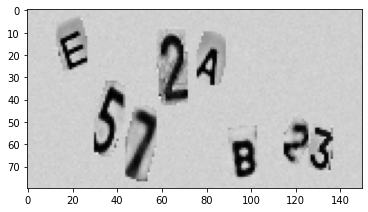

In [4]:
plate_ = plate()
# print(plate_.annot)
plate_.viewImage()

In [5]:
plate_.annot

[{'sym': '13', 'x_min': 13, 'y_min': 3, 'h': 24, 'w': 13},
 {'sym': '5', 'x_min': 30, 'y_min': 31, 'h': 34, 'w': 13},
 {'sym': '7', 'x_min': 44, 'y_min': 42, 'h': 34, 'w': 13},
 {'sym': '2', 'x_min': 58, 'y_min': 8, 'h': 34, 'w': 13},
 {'sym': '10', 'x_min': 75, 'y_min': 10, 'h': 24, 'w': 13},
 {'sym': '11', 'x_min': 90, 'y_min': 52, 'h': 24, 'w': 13},
 {'sym': '2', 'x_min': 114, 'y_min': 48, 'h': 21, 'w': 10},
 {'sym': '3', 'x_min': 126, 'y_min': 51, 'h': 21, 'w': 10}]

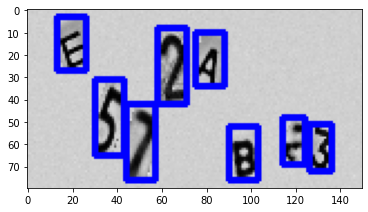

In [6]:
plate_rects = plate_.add_rectangles()
fig, ax = plt.subplots()
ax.imshow(cv2.cvtColor(plate_rects, cv2.COLOR_BGR2RGB))

Функция генерации изображения с номерными знаками:

In [9]:
def make_img_with_symbols():
    plate_ = plate()
    return  plate_

Тестовая генерация 3 изображений:

  0%|          | 0/3 [00:00<?, ?it/s]

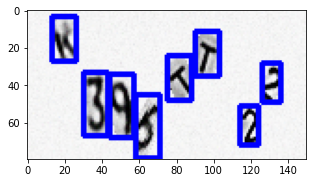

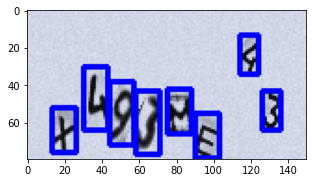

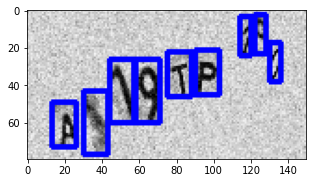

In [10]:
for i in tqdm(range(3)):
    new_pic = make_img_with_symbols()
    new_pic = new_pic.add_rectangles()
    fig, ax = plt.subplots(figsize=(5, 10))
    ax.imshow(cv2.cvtColor(new_pic.astype('uint8'), cv2.COLOR_BGR2RGB))

Генерируем 10000 изображений и формируем аннотацию:

In [11]:
N = 0
def make_annotation(pict, n):
    annot = {}
    an = []
    for i, r in enumerate(pict.annot):
        an.append({
                    "class": "rect",
                    "width": r['w'] ,
                    "height": r['h'],
                    "x": r['x_min']+r['w']/2,
                    "y": r['y_min']+r['h']/2,
                    "symbol": r['sym']})
    annot['annotation'] = an
    annot['class'] = 'image'
    annot['filename'] = "data\\synthetic_plates_val\\"+"plate_image_"+str(N)+"_"+str(n)+".JPG"
    return annot

In [12]:
if N==0:
    annotations = []
p_bar = tqdm(range(500))
for n in p_bar:
    pict = make_img_with_symbols()
    annot = make_annotation(pict, n)
    cv2.imwrite(annot['filename'], pict.image)
    annotations.append(annot)


  0%|          | 0/500 [00:00<?, ?it/s]

In [13]:
len(annotations)

500

In [14]:
annotations[0]

{'annotation': [{'class': 'rect',
   'width': 13,
   'height': 24,
   'x': 19.5,
   'y': 23.0,
   'symbol': '13'},
  {'class': 'rect',
   'width': 13,
   'height': 34,
   'x': 36.5,
   'y': 30.0,
   'symbol': '7'},
  {'class': 'rect',
   'width': 13,
   'height': 34,
   'x': 50.5,
   'y': 23.0,
   'symbol': '1'},
  {'class': 'rect',
   'width': 13,
   'height': 34,
   'x': 64.5,
   'y': 28.0,
   'symbol': '0'},
  {'class': 'rect',
   'width': 13,
   'height': 24,
   'x': 81.5,
   'y': 19.0,
   'symbol': '17'},
  {'class': 'rect',
   'width': 13,
   'height': 24,
   'x': 96.5,
   'y': 19.0,
   'symbol': '18'},
  {'class': 'rect',
   'width': 10,
   'height': 21,
   'x': 119.0,
   'y': 15.5,
   'symbol': '1'},
  {'class': 'rect',
   'width': 10,
   'height': 21,
   'x': 131.0,
   'y': 25.5,
   'symbol': '8'}],
 'class': 'image',
 'filename': 'data\\synthetic_plates_val\\plate_image_0_0.JPG'}

In [15]:
import json
with open(os.path.join('data', 'syn_plates_val_annotations.json'), "w", encoding="utf-8") as file:
    json.dump(annotations, file)